## Transfer Learning

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from tqdm import tqdm
import torchvision.models as models
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [11]:
train_tranform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(((0.5, 0.5, 0.5)), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(((0.5, 0.5, 0.5)), (0.5, 0.5, 0.5))
])

In [12]:
train_dataset = datasets.Flowers102(root="./data", split="train", download=True, transform=train_tranform)
test_dataset = datasets.Flowers102(root="./data", split="val", download=True, transform=test_transform)

In [22]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

In [13]:
indices = torch.randint(len(train_dataset), (5,))
samples = [train_dataset[i] for i in indices]

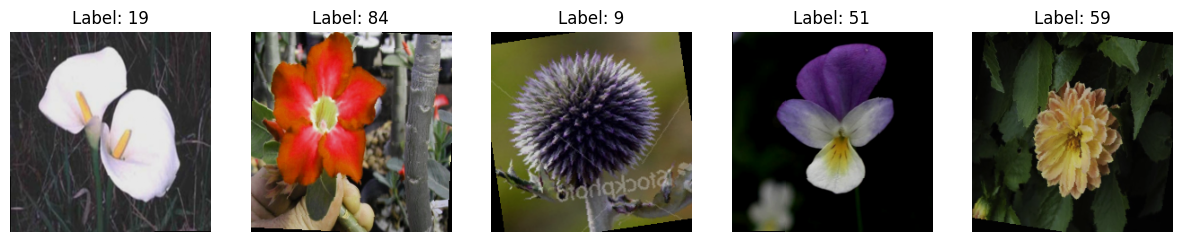

In [15]:
fig, axes = plt.subplots(1, 5, figsize = (15, 5))
for i, (image, label) in enumerate(samples):
    image = image.numpy().transpose((1, 2, 0))
    image = (image * 0.5) + 0.5
    axes[i].imshow(image)
    axes[i].set_title(f"Label: {label}")
    axes[i].axis("off")
plt.show()

In [16]:
model = models.mobilenet_v2(pretrained = True)

/home/emin/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/emin/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /home/emin/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:07<00:00, 1.97MB/s]


In [17]:
num_ftrs = model.classifier[1].in_features

In [18]:
model.classifier[1] = nn.Linear(num_ftrs, 102)

In [19]:
model = model.to(device=device)

In [21]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.classifier[1].parameters(), lr=1e-3)  
scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=5, gamma=0.1)

In [24]:
epochs = 3
for epoch in tqdm(range(epochs)):
    model.train()
    running_loss = 0.0
    for images, labels in train_dataloader:
        images, labels = images.to(device=device), labels.to(device=device)
        optimizer.zero_grad()
        output = model(images)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    scheduler.step()
    print(f"Epoch {epoch+1}: Loss: {running_loss/len(train_dataloader)}")

 33%|███▎      | 1/3 [00:10<00:20, 10.46s/it]

Epoch 1: Loss: 3.508023478090763


 67%|██████▋   | 2/3 [00:20<00:10, 10.49s/it]

Epoch 2: Loss: 2.40356682240963


100%|██████████| 3/3 [00:31<00:00, 10.51s/it]

Epoch 3: Loss: 1.6862422227859497


In [25]:
torch.save(model.state_dict(), "mobilenet_flowers102.pth")

In [28]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_dataloader):
        images, labels = images.to(device=device), labels.to(device=device)
        output = model(images)
        _, predicted = torch.max(output, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

100%|██████████| 32/32 [00:04<00:00,  7.61it/s]


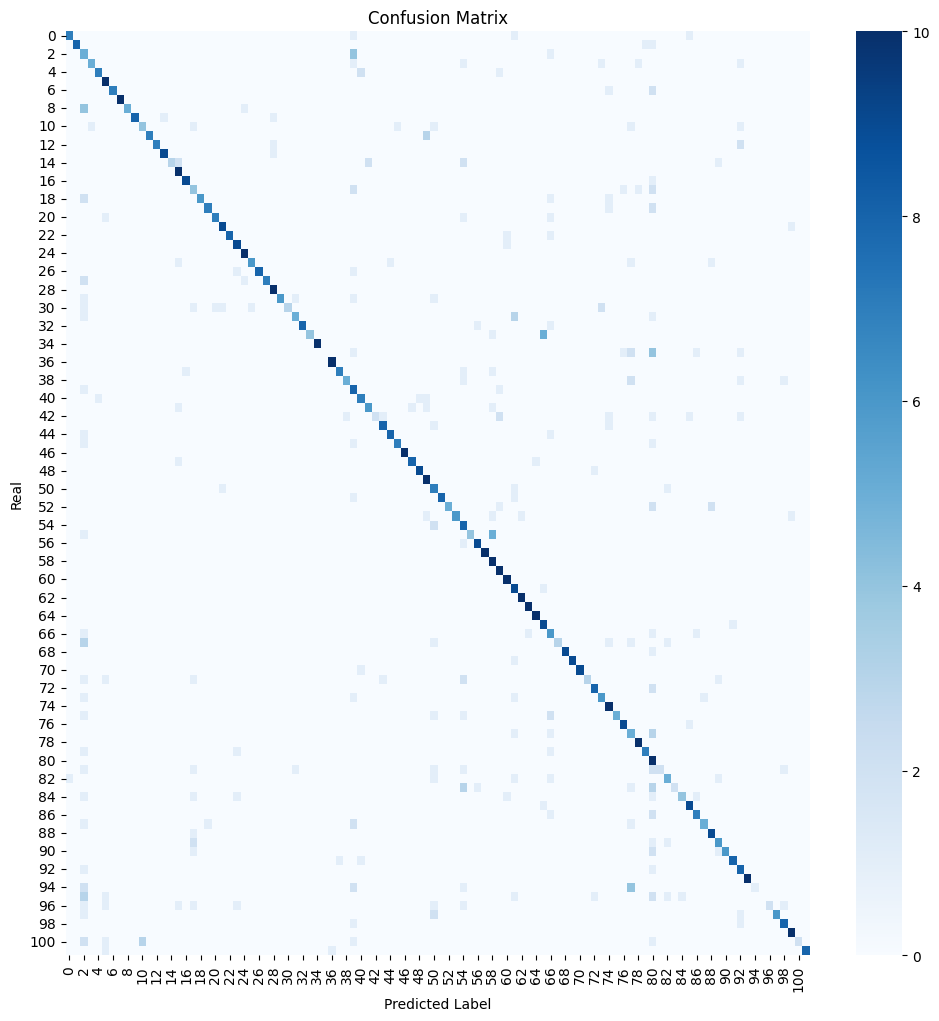

In [31]:
cm = confusion_matrix(y_true=all_labels, y_pred=all_preds)
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("Real")
plt.title("Confusion Matrix")
plt.show()

In [33]:
from sklearn.metrics import classification_report

print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       1.00      0.80      0.89        10
           2       0.12      0.50      0.20        10
           3       0.83      0.50      0.62        10
           4       0.88      0.70      0.78        10
           5       0.62      1.00      0.77        10
           6       1.00      0.70      0.82        10
           7       1.00      1.00      1.00        10
           8       1.00      0.50      0.67        10
           9       1.00      0.80      0.89        10
          10       0.57      0.40      0.47        10
          11       1.00      0.70      0.82        10
          12       1.00      0.70      0.82        10
          13       0.90      0.90      0.90        10
          14       1.00      0.30      0.46        10
          15       0.62      1.00      0.77        10
          16       0.90      0.90      0.90        10
          17       0.29    

/home/emin/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/emin/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/emin/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
